In [2]:
import torch
import torch.nn as nn
import torch.distributions as D
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import numpy as np

RealNVP - генеративная модель глубокого обучения, основанная на нормализующих потоках. Нормализующий поток выполняет задачу отображения сэмпла данных из некоторого простого распределения (удобного для сэмплирования - например, нормального) в более сложное, которое мы и хотим научиться моделировать. Кроме того, поток поддерживает и обратное, нормализующее отображение.
Отличием нормализующих потоков от прочих генеративных вероятностных моделей, состоит в точном вычислении функции правдоподобия, которая, в свою очередь, вычисляется с помощью формулы замены переменной.

$$
f_Y(y) = f_X(g^{-1}(y)) \cdot \left|  J^{-1}f_X \right|
$$

Соответственно, необходимо уметь эффективно вычислять якобиан. Ниже представлена реализация модели RealNVP, в основе которой лежит использование функции специального вида, позволяющей простым способом вычислять якобиан.


In [2]:
X, y = make_moons(n_samples=1000, noise=0.05)

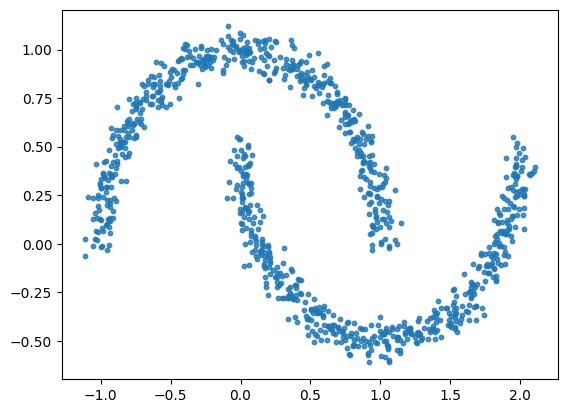

In [3]:
plt.scatter(X[:, 0], X[:, 1], s=10, alpha=0.8)
plt.show()

# Архитектура RealNVP

Основой архитектуры являются блоки **афинного связывания**. Каждый такой блок моделирует функцию отображения из латентного пространства в исследуемое. Функция организована в виде двух нейросетей (scale_net = s, translation_net = t), который действуют на входной тензор (в данной реализации - просто вектор). Изначально, вектор частично маскируется, и только часть выходных каналов будет изменена, остальные останутся шумом. Изменные каналы пройдут через нейронные сети.
Якобиан такой трансформации будет матрицей треугольного вида и легко вычисляем.

$$
y_{1:d} = x_{1:d} \quad (1)
$$

$$
y_{d+1:D} = x_{d+1:D} \cdot \exp(s(x_{1:d})) + t(x_{1:d}) \quad (2)
$$

Обе нейронные сети спроектированы как обычный MLP. В случае если данные - изображения, уместно будет обе сети представить как CNN.

In [9]:
class AffineCoupleLayer(nn.Module):
  def __init__(self, hidden_dim, mask):
    super(AffineCoupleLayer, self).__init__()
    self.mask = mask
    input_dim = len(self.mask)

    self.scale_net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim * 2),
        nn.ReLU(),
        nn.Linear(hidden_dim * 2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim),
        nn.ReLU()
    )

    self.translation_net = nn.Sequential(
        nn.Linear(input_dim, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, hidden_dim * 2),
        nn.ReLU(),
        nn.Linear(hidden_dim * 2, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim)
    )

  def forward(self, x):
    mask = self.mask.to(x.device)
    x1 = x * mask #маскируем, чтобы зафиксировать часть, которую не будем менять
    t = self.translation_net(x1)
    s = self.scale_net(x1) * (1 - mask)
    z = x1 + (1 - mask) * (x * torch.exp(s) + t)
    log_det_jacobian = torch.sum(s, dim=1) # якобиан трансформации - произведение единичной матрицы и диагональной
    return z, log_det_jacobian

  # "нормализующий" проход - восстановление латентного вектора
  def backward(self, z):
    mask = self.mask.to(z.device)
    z1 = z * mask
    t = self.translation_net(z1)
    s = self.scale_net(z1) * (1 - mask)
    x = z1 + (1 - mask) * (z - t) * torch.exp(-s)
    log_det_jacobian = torch.sum(s, dim=1)
    return x, log_det_jacobian




Блоки афинного связывания идут последовательно и в каждом применяется своя маска для входных данных - чтобы сделать модель выразительной и обучить моделировать каждый канал.

In [10]:
class RealNVP(nn.Module):
    def __init__(self, num_blocks, hidden_dim, masks):
        super(RealNVP, self).__init__()
        self.dim = len(masks[0])
        self.blocks = nn.ModuleList([AffineCoupleLayer(hidden_dim, masks[i]) for i in range(num_blocks)]) #cсобираем блоки по количеству заданных масок
        self.base_distribution = D.MultivariateNormal(torch.zeros(self.dim).to(device), torch.eye(self.dim).to(device)) # исходный многомерный нормальный шум


    def forward(self, x):
        log_det_jacobian_total = 0
        z = x
        for block in self.blocks:
            z, log_det_jacobian = block(z)
            log_det_jacobian_total += log_det_jacobian
        return z, log_det_jacobian_total

    def inverse(self, z):
        log_det_jacobian_total = 0
        x = z
        for block in reversed(self.blocks):
            x, log_det_jacobian = block.backward(x)
            log_det_jacobian_total += log_det_jacobian
        return x, log_det_jacobian_total

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_jacobian

In [53]:

def train_realnvp(model, num_epochs=1000, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in tqdm(range(num_epochs)):

        x_train, _ = make_moons(n_samples=512, noise=0.05)
        x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
        loss = -(model.log_prob(x_train)).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()




In [62]:
dim = 2
hidden_dim = 128
num_blocks = 8
masks = []
for i in range(num_blocks):
    mask = torch.zeros(dim)
    mask[i % dim] = 1
    masks.append(mask)

model = RealNVP(num_blocks=num_blocks, hidden_dim=hidden_dim, masks=masks)


train_realnvp(model)

  0%|          | 2/1000 [00:00<01:56,  8.60it/s]

Epoch [0/1000], Loss: 2.5883


 10%|█         | 102/1000 [00:13<01:47,  8.37it/s]

Epoch [100/1000], Loss: -14.8354


 12%|█▏        | 122/1000 [00:16<01:55,  7.57it/s]


ValueError: Expected value argument (Tensor of shape (512, 2)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([2]), covariance_matrix: torch.Size([2, 2])), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        ...,
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<NativeBatchNormBackward0>)

In [45]:

def visualize(model, n_samples=512, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)
    x_new, labels = make_moons(n_samples=n_samples, noise=0.05)
    x_new = torch.tensor(x_new, dtype=torch.float32).to(device)

    # Трансформация в латентное пространство через модель RealNVP
    with torch.no_grad():
        z, _ = model.forward(x_new)

    x_new = x_new.cpu().numpy()
    z = z.cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    colors = ['blue', 'green']

    # Исходное пространство
    for label in np.unique(labels):
        ax[0].scatter(x_new[labels == label][:, 0], x_new[labels == label][:, 1], color=colors[label], alpha=0.5, label=f'Class {label}')
    ax[0].set_title('Исходное пространство (make_moons)')
    ax[0].legend()

    # Латентное пространство
    for label in np.unique(labels):
        ax[1].scatter(z[labels == label][:, 0], z[labels == label][:, 1], color=colors[label], alpha=0.5, label=f'Class {label}')
    ax[1].set_title('Латентное пространство (RealNVP)')
    ax[1].legend()

    plt.show()




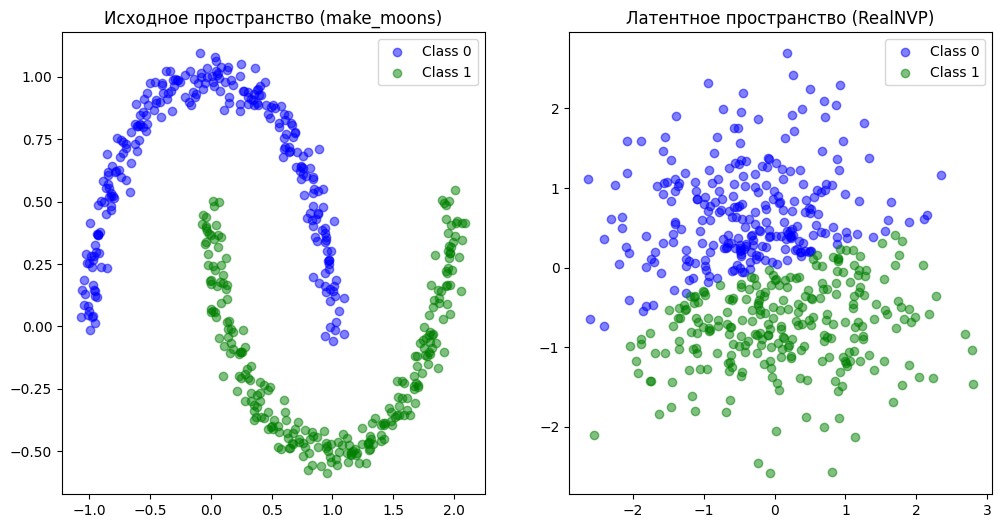

In [46]:
visualize(model)

In [48]:
def visualize_from_latent(model, n_samples=512, device="cuda" if torch.cuda.is_available() else "cpu"):
    model.to(device)

    # Сэмплирование из нормального распределения
    latent_dim = model.dim
    base_dist = D.MultivariateNormal(torch.zeros(latent_dim).to(device), torch.eye(latent_dim).to(device))
    z_samples = base_dist.sample((n_samples,))

    # Преобразование семпла в исходное пространство через обратный проход модели
    with torch.no_grad():
        x_samples, _ = model.inverse(z_samples)


    z_samples = z_samples.cpu().numpy()
    x_samples = x_samples.cpu().numpy()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].scatter(z_samples[:, 0], z_samples[:, 1], color='red', alpha=0.5)
    ax[0].set_title('Сэмплы в латентном пространстве')


    ax[1].scatter(x_samples[:, 0], x_samples[:, 1], color='blue', alpha=0.5)
    ax[1].set_title('Преобразованные сэмплы в исходном пространстве')

    plt.show()



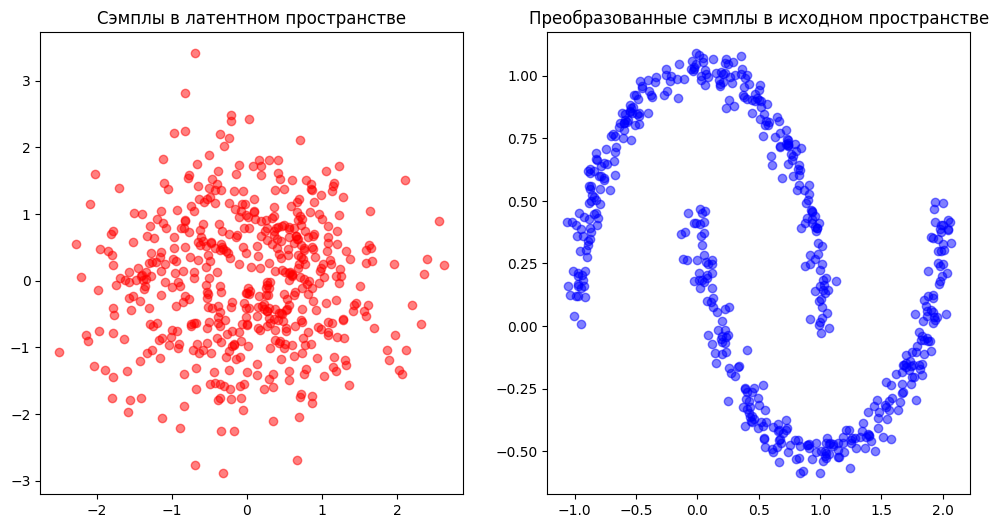

In [49]:
visualize_from_latent(model)

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Пример использования:
model = RealNVP(num_blocks, hidden_dim, masks)  # Ваша модель
num_params = count_parameters(model)
print(f'Количество параметров в модели: {num_params}')


Количество параметров в модели: 1191944


# MNIST

In [10]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

  2%|▏         | 1/50 [00:15<12:25, 15.22s/it]

Epoch [0/50], Loss: 816.2792


  4%|▍         | 2/50 [00:30<12:14, 15.30s/it]

Epoch [1/50], Loss: 737.3955


  6%|▌         | 3/50 [00:46<12:09, 15.52s/it]

Epoch [2/50], Loss: 721.3995


  8%|▊         | 4/50 [01:01<11:50, 15.44s/it]

Epoch [3/50], Loss: 720.9550


 10%|█         | 5/50 [01:17<11:34, 15.43s/it]

Epoch [4/50], Loss: 720.6890


 12%|█▏        | 6/50 [01:32<11:12, 15.28s/it]

Epoch [5/50], Loss: 720.5905


 14%|█▍        | 7/50 [01:47<10:54, 15.23s/it]

Epoch [6/50], Loss: 752.5391


 16%|█▌        | 8/50 [02:02<10:45, 15.38s/it]

Epoch [7/50], Loss: 720.7145


 18%|█▊        | 9/50 [02:17<10:26, 15.28s/it]

Epoch [8/50], Loss: 720.6024


 20%|██        | 10/50 [02:32<10:03, 15.09s/it]

Epoch [9/50], Loss: 720.5483


 22%|██▏       | 11/50 [02:47<09:42, 14.93s/it]

Epoch [10/50], Loss: 720.5202


 24%|██▍       | 12/50 [03:02<09:25, 14.89s/it]

Epoch [11/50], Loss: 720.5050


 26%|██▌       | 13/50 [03:16<09:08, 14.84s/it]

Epoch [12/50], Loss: 720.5197


 28%|██▊       | 14/50 [03:32<09:04, 15.12s/it]

Epoch [13/50], Loss: 720.5044


 30%|███       | 15/50 [03:47<08:47, 15.06s/it]

Epoch [14/50], Loss: 720.4928


 32%|███▏      | 16/50 [04:02<08:30, 15.03s/it]

Epoch [15/50], Loss: 720.4838


 34%|███▍      | 17/50 [04:17<08:14, 15.00s/it]

Epoch [16/50], Loss: 720.4969


 36%|███▌      | 18/50 [04:32<07:58, 14.95s/it]

Epoch [17/50], Loss: 720.4796


 38%|███▊      | 19/50 [04:47<07:45, 15.03s/it]

Epoch [18/50], Loss: 720.4877


 40%|████      | 20/50 [05:02<07:33, 15.10s/it]

Epoch [19/50], Loss: 720.4758


 42%|████▏     | 21/50 [05:17<07:16, 15.07s/it]

Epoch [20/50], Loss: 720.4697


 44%|████▍     | 22/50 [05:32<07:02, 15.08s/it]

Epoch [21/50], Loss: 720.4779


 46%|████▌     | 23/50 [05:47<06:46, 15.05s/it]

Epoch [22/50], Loss: 720.4760


 48%|████▊     | 24/50 [06:02<06:29, 15.00s/it]

Epoch [23/50], Loss: 720.4598


 50%|█████     | 25/50 [06:18<06:19, 15.18s/it]

Epoch [24/50], Loss: 720.4614


 52%|█████▏    | 26/50 [06:33<06:02, 15.09s/it]

Epoch [25/50], Loss: 720.4596


 54%|█████▍    | 27/50 [06:47<05:46, 15.05s/it]

Epoch [26/50], Loss: 720.4652


 56%|█████▌    | 28/50 [07:02<05:29, 14.96s/it]

Epoch [27/50], Loss: 720.4603


 58%|█████▊    | 29/50 [07:17<05:13, 14.92s/it]

Epoch [28/50], Loss: 720.4580


 60%|██████    | 30/50 [07:32<04:59, 14.98s/it]

Epoch [29/50], Loss: 720.4567


 62%|██████▏   | 31/50 [07:48<04:48, 15.17s/it]

Epoch [30/50], Loss: 720.4567


 64%|██████▍   | 32/50 [08:03<04:31, 15.08s/it]

Epoch [31/50], Loss: 720.4582


 66%|██████▌   | 33/50 [08:17<04:14, 14.98s/it]

Epoch [32/50], Loss: 720.4538


 68%|██████▊   | 34/50 [08:32<03:59, 14.94s/it]

Epoch [33/50], Loss: 720.4556


 70%|███████   | 35/50 [08:47<03:43, 14.93s/it]

Epoch [34/50], Loss: 720.4532


 72%|███████▏  | 36/50 [09:03<03:30, 15.05s/it]

Epoch [35/50], Loss: 720.4531


 74%|███████▍  | 37/50 [09:18<03:16, 15.12s/it]

Epoch [36/50], Loss: 720.4562


 76%|███████▌  | 38/50 [09:33<03:00, 15.04s/it]

Epoch [37/50], Loss: 720.4526


 78%|███████▊  | 39/50 [09:48<02:45, 15.04s/it]

Epoch [38/50], Loss: 720.4536


 80%|████████  | 40/50 [10:03<02:30, 15.03s/it]

Epoch [39/50], Loss: 720.4530


 82%|████████▏ | 41/50 [10:18<02:15, 15.05s/it]

Epoch [40/50], Loss: 720.4567


 84%|████████▍ | 42/50 [10:33<02:01, 15.19s/it]

Epoch [41/50], Loss: 720.4536


 86%|████████▌ | 43/50 [10:48<01:45, 15.10s/it]

Epoch [42/50], Loss: 720.4587


 88%|████████▊ | 44/50 [11:03<01:30, 15.03s/it]

Epoch [43/50], Loss: 720.4517


 90%|█████████ | 45/50 [11:18<01:14, 14.98s/it]

Epoch [44/50], Loss: 720.4530


 92%|█████████▏| 46/50 [11:33<00:59, 14.91s/it]

Epoch [45/50], Loss: 720.4524


 94%|█████████▍| 47/50 [11:48<00:44, 14.97s/it]

Epoch [46/50], Loss: 720.4545


 96%|█████████▌| 48/50 [12:03<00:30, 15.09s/it]

Epoch [47/50], Loss: 720.4529


 98%|█████████▊| 49/50 [12:18<00:15, 15.09s/it]

Epoch [48/50], Loss: 720.4502


100%|██████████| 50/50 [12:33<00:00, 15.07s/it]

Epoch [49/50], Loss: 720.4509


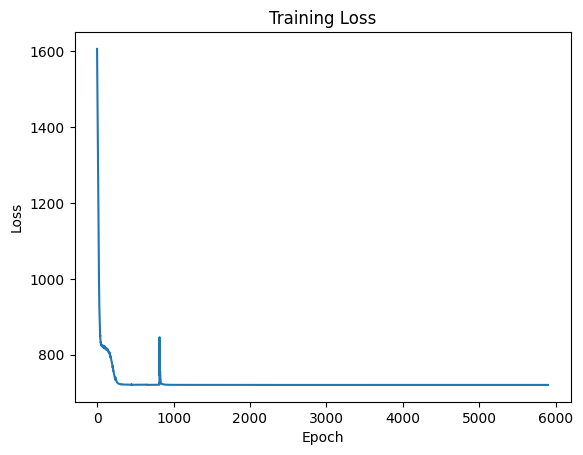

In [48]:
import torch
import torch.nn as nn
import torch.distributions as D
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

# Определение масок
def create_masks(dim, num_masks):
    masks = []
    for i in range(num_masks):
        mask = torch.zeros(dim)
        if i % 2 == 0:
            mask[::2] = 1  # 1 на четных индексах для четных i
        else:
            mask[1::2] = 1  # 1 на нечетных индексах для нечетных i
        masks.append(mask)
    return masks

# Загрузка MNIST без нормализации
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((-.5,), (-.5,))])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_loader = DataLoader(mnist_dataset, batch_size=512, shuffle=True)

# Изменение модели RealNVP
class AffineCoupleLayer(nn.Module):
    def __init__(self, hidden_dim, mask):
        super(AffineCoupleLayer, self).__init__()
        self.mask = mask
        input_dim = len(self.mask)

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.LeakyReLU()
        )

        self.translation_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        mask = self.mask.to(x.device)  # Убедитесь, что маска на правильном устройстве
        x1 = x * mask  # Маскируем, чтобы зафиксировать часть, которую не будем менять
        t = self.translation_net(x1)
        s = self.scale_net(x1) * (1 - mask)
        z = x1 + (1 - mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)  # Якобиан трансформации - произведение единичной матрицы и диагональной
        return z, log_det_jacobian

    def backward(self, z):
        mask = self.mask.to(z.device)
        z1 = z * mask
        t = self.translation_net(z1)
        s = self.scale_net(z1) * (1 - mask)
        x = z1 + (1 - mask) * (z - t) * torch.exp(-s)
        log_det_jacobian = torch.sum(s, dim=1)
        return x, log_det_jacobian

class RealNVP(nn.Module):
    def __init__(self, num_blocks, hidden_dim):
        super(RealNVP, self).__init__()
        self.dim = 28 * 28  # Размер изображения MNIST
        masks = create_masks(self.dim, num_blocks)
        self.blocks = nn.ModuleList([AffineCoupleLayer(hidden_dim, masks[i]) for i in range(num_blocks)])
        self.base_distribution = D.MultivariateNormal(torch.zeros(self.dim).to(device), torch.eye(self.dim).to(device))

    def forward(self, x):
        log_det_jacobian_total = 0
        z = x
        for block in self.blocks:
            z, log_det_jacobian = block(z)
            log_det_jacobian_total += log_det_jacobian
        return z, log_det_jacobian_total

    def inverse(self, z):
        log_det_jacobian_total = 0
        x = z
        for block in reversed(self.blocks):
            x, log_det_jacobian = block.backward(x)
            log_det_jacobian_total += log_det_jacobian
        return x, log_det_jacobian_total

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_jacobian

# Тренировочный цикл для MNIST
def train_realnvp_mnist(model, num_epochs=50, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    losses = []

    for epoch in tqdm(range(num_epochs)):
        for x_train, _ in mnist_loader:
            x_train = x_train.view(-1, 28 * 28).to(device)  # Преобразуем изображения в векторы

            z, log_det_jacobian = model.forward(x_train)
            log_prob = model.base_distribution.log_prob(z)
            loss = -(log_prob).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

# Настройка устройства и создание модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RealNVP(num_blocks=6, hidden_dim=256)  # Настройте количество блоков и размер скрытого слоя

# Запуск тренировки
train_realnvp_mnist(model)


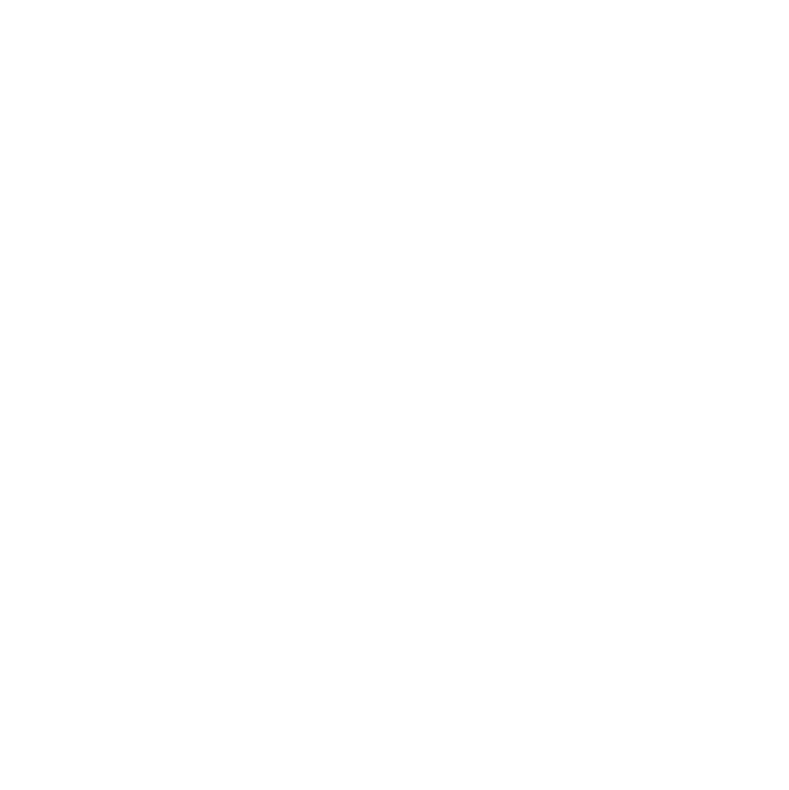

In [52]:
import numpy as np

# Функция для генерации и визуализации сэмплов
def visualize_samples(model, num_samples=64):
    model.eval()  # Переключаем модель в режим оценки

    # Генерируем сэмплы из базового нормального распределения
    with torch.no_grad():
        z = model.base_distribution.sample((num_samples,))  # Сэмплы из нормального распределения
        x, _ = model.inverse(z)  # Применяем обратную трансформацию модели

        # Преобразуем выходные данные в нужный формат для визуализации
        x = x.view(-1, 28, 28).cpu().numpy()  # Переводим на CPU и преобразуем к [num_samples, 28, 28]

    # Визуализируем сгенерированные изображения
    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    axs = axs.flatten()

    for img, ax in zip(x, axs):
        ax.imshow(img, cmap='gray')
        ax.axis('off')  # Убираем оси для изображения

    plt.tight_layout()
    plt.show()

# Вызов функции визуализации
visualize_samples(model)


# Batch

In [61]:
import torch.nn as nn
import torch.distributions as D
import torch
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

class AffineCoupleLayer(nn.Module):
    def __init__(self, hidden_dim, mask):
        super(AffineCoupleLayer, self).__init__()
        self.mask = mask
        input_dim = len(self.mask)

        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.ReLU()
        )

        self.translation_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        mask = self.mask.to(x.device)
        x1 = x * mask  # Маскируем, чтобы зафиксировать часть, которую не будем менять
        t = self.translation_net(x1)
        s = self.scale_net(x1) * (1 - mask)
        z = x1 + (1 - mask) * (x * torch.exp(s) + t)
        log_det_jacobian = torch.sum(s, dim=1)  # Якобиан трансформации - произведение единичной матрицы и диагональной
        return z, log_det_jacobian

    def backward(self, z):
        mask = self.mask.to(z.device)
        z1 = z * mask
        t = self.translation_net(z1)
        s = self.scale_net(z1) * (1 - mask)
        x = z1 + (1 - mask) * (z - t) * torch.exp(-s)
        log_det_jacobian = torch.sum(s, dim=1)
        return x, log_det_jacobian

class BatchNormLayer(nn.Module):
    def __init__(self, num_features):
        super(BatchNormLayer, self).__init__()
        self.batch_norm = nn.BatchNorm1d(num_features)

    def forward(self, x):
        # Применяем батч-нормализацию
        self.batch_norm(x)
        return self.batch_norm(x)

    def log_det_jacobian(self):
        # Вычисляем лог-детерминант
        batch_var = self.batch_norm.running_var  # используем статистику в режиме inference
        return (torch.prod(batch_var ** 2 + self.batch_norm.eps)) ** (-1 / 2)


class RealNVP(nn.Module):
    def __init__(self, num_blocks, hidden_dim, masks):
        super(RealNVP, self).__init__()
        self.dim = len(masks[0])
        self.blocks = nn.ModuleList()
        self.batch_norm = BatchNormLayer(self.dim)
        for i in range(num_blocks):
            self.blocks.append(AffineCoupleLayer(hidden_dim, masks[i]))

        self.base_distribution = D.MultivariateNormal(torch.zeros(self.dim).to(device), torch.eye(self.dim).to(device))

    def forward(self, x):
        log_det_jacobian_total = 0
        z = x
        for block in self.blocks:
            z, log_det_jacobian = block(z)
            log_det_jacobian_total += log_det_jacobian

            # Проходим через слой батч-нормализации
            z = self.batch_norm(z)
            log_det_jacobian += self.batch_norm.log_det_jacobian()  # Добавляем вклад к лог-детерминанту

        return z, log_det_jacobian_total

    def inverse(self, z):
        log_det_jacobian_total = 0
        x = z
        for block in reversed(self.blocks):
            x, log_det_jacobian = block.backward(x)
            log_det_jacobian_total += log_det_jacobian

            # Обратный проход через слой батч-нормализации (не требуется добавление, так как это уже делает прямой проход)
            x = self.batch_norm(x)

        return x, log_det_jacobian_total

    def log_prob(self, x):
        z, log_det_jacobian = self.forward(x)
        log_prob_z = self.base_distribution.log_prob(z)
        return log_prob_z + log_det_jacobian


# Функция тренировки модели
def train_realnvp(model, num_epochs=1000, lr=1e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []

    for epoch in tqdm(range(num_epochs)):

        x_train, _ = make_moons(n_samples=512, noise=0.05)
        x_train = torch.tensor(x_train, dtype=torch.float32).to(device)
        loss = -(model.log_prob(x_train)).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if epoch % 100 == 0:
            print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

